In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

N_SAMPLES = 1000

%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [2]:
with open("data/EIG.txt", "r+") as file:
    raw_content = file.readlines()
    file.seek(0)
    if raw_content[1] == "\n":
        raw_content.pop(1)
    file.writelines(raw_content)

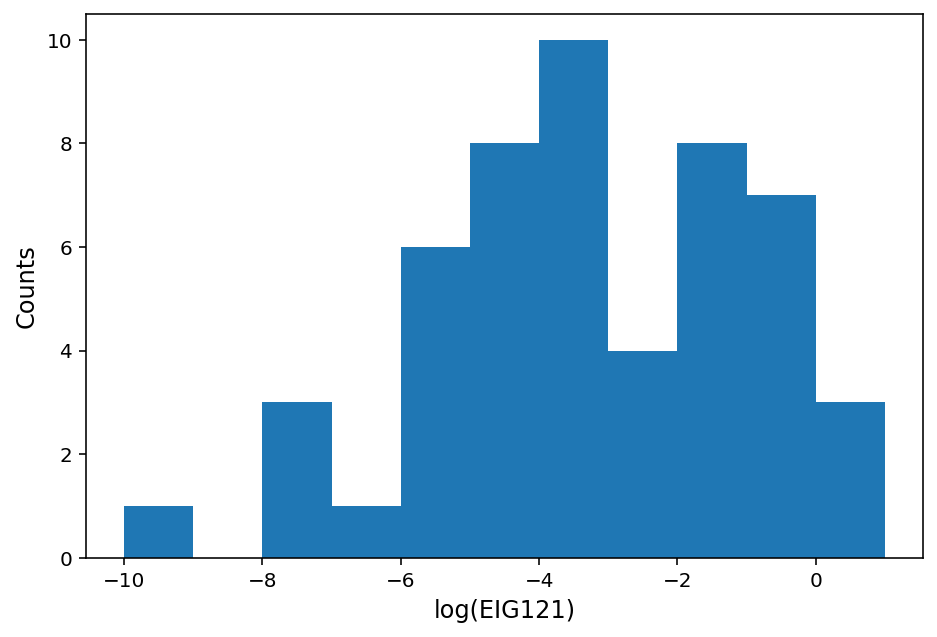

In [3]:
data = pd.read_csv("data/EIG.txt", delimiter=" ", skipinitialspace=True, index_col=0)
y = data.filter(regex="recorded").dropna().values.reshape(-1,)
y = np.log(y); n = len(y)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 5))
_ = plt.hist(y, bins=11, range=[-10, 1])
_ = ax.set_xlabel("log(EIG121)", fontsize=12)
_ = ax.set_ylabel("Counts", fontsize=12)

In [4]:
a = 1; b = 1 # 1/var ~ Gamma(a, b)
m0 = -3; B0 = 4 # G0 \equiv N(m0, B0)
M = 1
H = 10

In [5]:
def init_dpk():
    _mh = np.array(
        [
            -3.8463066, 
            -0.1905842,
            -5.5525835,
            -1.2400170,
            -2.5141986,
            -7.6999043,
            -4.7465500,
            -1.8224127,
            -9.4334839,
            -6.2554301,
        ]
    )
    _wh = np.array(
        [
            0.29411765,
            0.17647059,
            0.11764706,
            0.11764706,
            0.07843137,
            0.05882353,
            0.05882353,
            0.05882353,
            0.01960784,
            0.01960784,
        ]
    )
    _r = np.array(
        [1, 2, 3, 4, 5, 6, 2, 2, 2, 5, 2, 2, 5, 7, 1, 7, 2, 2, 2, 8, 8, 2, 8, 5, 9, 8, 8, 2, 10, 6, 2, 6, 4, 4, 8, 8, 1, 2, 9, 1, 4, 4, 8, 9, 2, 8, 2, 1, 1, 4, 7]
    )
    _sig = 0.1
    
    return _mh, _wh, _r, _sig

In [33]:
np.exp(-1/2)*1/np.sqrt(2*np.pi)

0.24197072451914337

In [31]:
norm.pdf(x=0, loc=np.array([-1, 0, 1]), scale=1)

array([0.24197072, 0.39894228, 0.24197072])

In [16]:
def sample_r(_wh, _mh, _sig, _y=y):
    '''
    sample allocation indicators...?
    '''
    _r = []
    
    for yi in _y:
        ph = norm.pdf(x=yi, loc=_mh, scale=_sig)*_wh
        _r.append(np.random.choice(range(H), size=1, replace=True, p=ph/ph.sum()))
        
    return np.array(_r).reshape(-1,)


def sample_mh(_wh, _r, _sig):
    _mh = []
    
    for h in range(H):
        if any(_r == h):
            Sh = np.where(_r == h)[0]
            nh = len(Sh)
            ybarh = y[Sh].mean()
            varh = 1/(1/B0 + nh/(_sig**2))
            meanh = varh*(m0/B0 + nh*ybarh/(_sig**2))
        else:
            varh = B0
            meanh = B0
        
        _mh.append(np.random.normal(loc=meanh, scale=np.sqrt(varh), size=1))
        
    return np.array(_mh).reshape(-1,)


def sample_vh(_r):
    _vh = []
    _wh = []
    V = 1 # for stick-breaking process
    
    for h in range(H-1):
        Ah = np.where(_r == h)[0]
        Bh = np.where(_r > h)[0]
        _vh.append(np.random.beta(1 + len(Ah), M + len(Bh), size=1))
        _wh.append(_vh[-1]*V)
        V *= (1 - _vh[-1])
    
    _vh.append(1)
    _wh.append(V)
    
    return np.array(_wh).reshape(-1,) # sums to 1


def sample_sig(_th):
    s2 = ((y - _th)**2).sum()
    a1 = a + 0.5*n
    b1 = b + 0.5*s2
    s2_inv = np.random.gamma(a1, b1, size=1)
    
    return float(1/np.sqrt(s2_inv))


def fbar_H(_x_grid, _wh, _mh, _sig):
    
    fx = np.zeros_like(_x_grid)
    
    for h in range(H):
        fx += _wh[h]*norm.pdf(x=_x_grid, loc=_mh[h], scale=_sig)
        
    return fx


def gibbs_H(n_iter):
    mh, wh, r, sig = init_dpk()
    
    x_grid = np.linspace(-10, 2, num=101)
    
    for _iter in range(n_iter):
        r = sample_r(wh, mh, sig)
        mh = sample_mh(wh, r, sig)
        vh = sample_vh(r)
        th = mh[r]
        sig = sample_sig(th)
        
        f = fbar_H(x_grid, wh, mh, sig)
        
        if _iter == 0:
            f_grid = f
            r_acc = r
            mh_acc = mh # acc for accumulation
            vh_acc = vh
            th_acc = th
            sig_acc = [sig]
        else:
            f_grid = np.vstack((f_grid, f))
            r_acc = np.vstack((r_acc, r))
            mh_acc = np.vstack((mh_acc, mh))
            vh_acc = np.vstack((vh_acc, vh))
            th_acc = np.vstack((th_acc, th))
            sig_acc.extend([sig])
            
    return {
        "f": f_grid, 
        "r": r_acc, 
        "mh": mh_acc, 
        "vh": vh_acc, 
        "th": th_acc,
        "sig": sig_acc,
    }

In [17]:
results = gibbs_H(n_iter=1000)

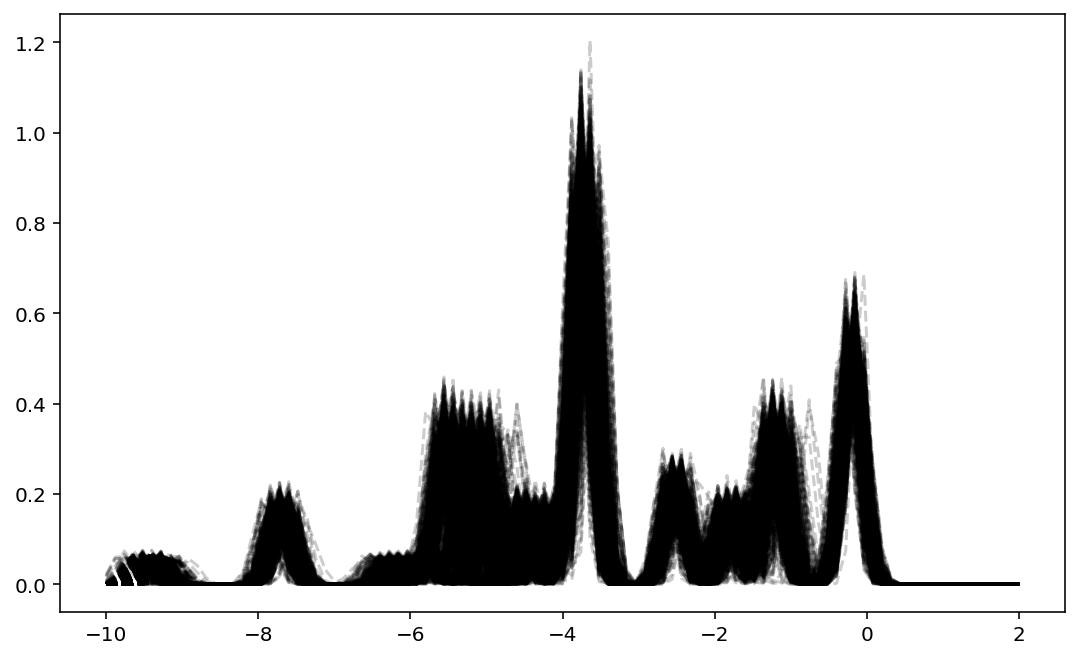

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5.5))

x_grid = np.linspace(-10, 2, num=101)

for i in range(N_SAMPLES):
    plt.plot(x_grid, results["f"][i], c="k", linestyle="--", alpha=0.2)